### Transfer Learning - EfficientNet

The goal of this competition is to develop a model capable of accurately predicting the flower depicted in an image.




   ## Contents:
* <h1 style="padding: 1rem;
          color:black;
          text-align:left;
          margin:0 auto;
          font-size:1.5rem;"><a href="#library">Libraries</a></h1>
* <h1 style="padding: 1rem;
          color:black;
          text-align:left;
          margin:0 auto;
          font-size:1.5rem;"><a href="#transform">Dataset Transform and Dataloader</a></h1>
* <h1 style="padding: 1rem;
          color:black;
          text-align:left;
          margin:0 auto;
          font-size:1.5rem;"><a href="#efficient">Transfer Learning On EfficientNet Model</a></h1>
               
* <h1 style="padding: 1rem;
          color:black;
          text-align:left;
          margin:0 auto;
          font-size:1.5rem;"><a href="#training">Configs and Training Loop</a></h1>

* <h1 style="padding: 1rem;
          color:black;
          text-align:left;
          margin:0 auto;
          font-size:1.5rem;"><a href="#submission">Inference and Submission</a></h1>

<div class="alert alert-warning" role="alert">
<a id="library"><h1 style="padding: 2rem;
          color:black;
          text-align:center;
          margin:0 auto;
          font-size:2rem;">
 Libraries
</h1></a>
</div>

In [1]:
!pip install tfrecord

import io
import pandas as pd
import tensorflow as tf
import timm
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import pandas as pd
import tfrecord
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torchvision
from torchinfo import summary
from PIL import Image
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
print(f"Make sure that the PyTorch version is the same as yours.")
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.9 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Make sure that the PyTorch version is the same as yours.
PyTorch version: 2.0.0
torchvision version: 0.15.1


In [2]:
FLOWER_NAMES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

if not device:
    print('CPU mode is on...')
else:
    print('GPU mode is on...')

GPU mode is on...


<div class="alert alert-warning" role="alert">
<a id="transform"><h1 style="padding: 2rem;
          color:black;
          text-align:center;
          margin:0 auto;
          font-size:2rem;">
 Dataset Transform
</h1></a>
</div>

In [4]:
DATASET_PATH = "/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224"

def transform_tf_to_df(subset_data):
    df = pd.DataFrame({"id": pd.Series(dtype="str"), 
                       "class": pd.Series(dtype="int"), 
                       "img": pd.Series(dtype="object")})    
    tf_files = []
    
    for subdir, dirs, files in os.walk(DATASET_PATH):
        if subdir.split("/")[-1] == subset_data:
            for file in files:
                filepath = subdir + os.sep + file
                tf_files.append(filepath)
                
    for tf_file in tf_files:
        if subset_data == "test":
            loader = tfrecord.tfrecord_loader(tf_file, None, {"id": "byte", "image": "byte"})
        else:
            loader = tfrecord.tfrecord_loader(tf_file, None, {"id": "byte","image": "byte", "class": "int"})
        
        for record in loader:
            id_label = record["id"].decode('utf-8')
            label = record["class"][0].item() if subset_data != "test" else None
            img_bytes = np.frombuffer(record["image"], dtype=np.uint8)
            img = cv2.imdecode(img_bytes, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            df.loc[len(df.index)] = [id_label, label, img]
    return df


In [5]:
df_validation = transform_tf_to_df('val')
df_train = transform_tf_to_df('train')
df_test = transform_tf_to_df('test')

In [6]:
CLASSES_NUM = len(FLOWER_NAMES)
CLASSES_NUM

104

id       object
class     int64
img      object
dtype: object (12753, 3)


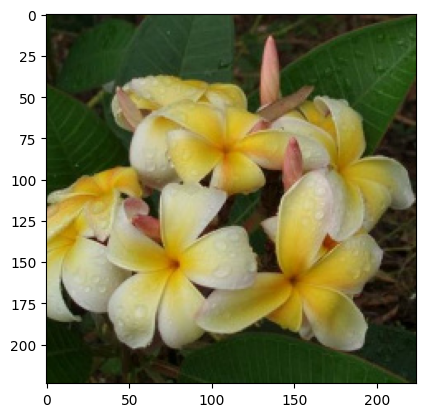

In [7]:
print(df_train.dtypes, df_train.shape)
plt.imshow(df_train.iloc[2]['img'])

In [8]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
class FlowersDataset(Dataset):
    def __init__(self, data, transform=None) -> None:
        self.data = data
        self.transform = transform
        
    def __getitem__(self, idx):
        "Iterable function which applies to each row"
        img_id = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]
        image = self.data.iloc[idx, 2]
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        y = np.zeros(CLASSES_NUM, dtype=np.float32)
        y[label] = int(1)
        return img_id, y, image
    
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.data)

In [10]:
train_data = FlowersDataset(df_train, transform=auto_transforms)
validation_data = FlowersDataset(df_validation, transform=auto_transforms)
test_data = FlowersDataset(df_test, transform=auto_transforms)

In [11]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=64,
                              num_workers=2)

validation_dataloader = DataLoader(dataset=validation_data, 
                              batch_size=64,
                              num_workers=1)

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=64, 
                             num_workers=1, 
                             shuffle=False)

In [12]:
print(f"Length of validation dataloader: {len(validation_dataloader)} batches of {64}")
image_id, label, image  = next(iter(validation_dataloader))

Length of validation dataloader: 58 batches of 64


In [13]:
image.shape, label.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 104]))

In [14]:
print(f"Length of test_dataloader dataloader: {len(test_dataloader)} batches of {64}")
image_id_test, label_test, image_test  = next(iter(test_dataloader))


Length of test_dataloader dataloader: 116 batches of 64


<div class="alert alert-warning" role="alert">
<a id="efficient"><h1 style="padding: 2rem;
          color:black;
          text-align:center;
          margin:0 auto;
          font-size:2rem;">
 Transfer Learning On EfficientNet Model
</h1></a>
</div>

In [15]:
model_effnet = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 134MB/s] 


In [16]:
summary(model=model_effnet, 
        input_size=(64, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=10,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape Output Shape Param #    Trainable
EfficientNet (EfficientNet)                                  [64, 3, 224, 224] [64, 1000] --         True
├─Sequential (features)                                      [64, 3, 224, 224] [64, 1280, 7, 7] --         True
│    └─Conv2dNormActivation (0)                              [64, 3, 224, 224] [64, 32, 112, 112] --         True
│    │    └─Conv2d (0)                                       [64, 3, 224, 224] [64, 32, 112, 112] 864        True
│    │    └─BatchNorm2d (1)                                  [64, 32, 112, 112] [64, 32, 112, 112] 64         True
│    │    └─SiLU (2)                                         [64, 32, 112, 112] [64, 32, 112, 112] --         --
│    └─Sequential (1)                                        [64, 32, 112, 112] [64, 16, 112, 112] --         True
│    │    └─MBConv (0)                                       [64, 32, 112, 112] [64, 16, 112, 112] 1,448

In [17]:
# Ensure that all base layers within the 'features' section of the model (which acts as the feature extractor) are frozen by assigning requires_grad=False."
for param in model_effnet.features.parameters():
    param.requires_grad = False

In [18]:
# Recreate the classifier layer
model_effnet.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=CLASSES_NUM, # same number of output units as our number of classes
                    bias=True)).to(device)

In [19]:
# Generate a summary following the freezing of the features and the modification of the output classifier layer
summary(model_effnet, 
        input_size=(64, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=9,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape Output Shape Param #   Trainable
EfficientNet (EfficientNet)                                  [64, 3, 224, 224] [64, 104] --        Partial
├─Sequential (features)                                      [64, 3, 224, 224] [64, 1280, 7, 7] --        False
│    └─Conv2dNormActivation (0)                              [64, 3, 224, 224] [64, 32, 112, 112] --        False
│    │    └─Conv2d (0)                                       [64, 3, 224, 224] [64, 32, 112, 112] (864)     False
│    │    └─BatchNorm2d (1)                                  [64, 32, 112, 112] [64, 32, 112, 112] (64)      False
│    │    └─SiLU (2)                                         [64, 32, 112, 112] [64, 32, 112, 112] --        --
│    └─Sequential (1)                                        [64, 32, 112, 112] [64, 16, 112, 112] --        False
│    │    └─MBConv (0)                                       [64, 32, 112, 112] [64, 16, 112, 112] (1,448

<div class="alert alert-warning" role="alert">
<a id="training"><h1 style="padding: 2rem;
          color:black;
          text-align:center;
          margin:0 auto;
          font-size:2rem;">
 Configs and Training Loop
</h1></a>
</div>

In [20]:
training_loss_count, validation_loss_count  = [], []

def accuracy_step(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_step,
               device: torch.device = device):
    
    train_loss, train_acc = 0, 0
    model.to(device)
    
    for img_ids, y, X in data_loader:
        X, y = X.to(device), y.to(device)
        #forward
        y_pred = model(X)
        #calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_step(y_true=y.argmax(dim=1), y_pred=y_pred.argmax(dim=1))
        #zerograd
        optimizer.zero_grad()
        #backward
        loss.backward()
        #optimizer
        optimizer.step()
    train_loss /= len(data_loader)
    training_loss_count.append(train_loss.cpu().item())
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    

def validation_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_step,
              device: torch.device = device):
    valid_loss, valid_acc = 0, 0
    model.to(device)
    model.eval()
    
    with torch.inference_mode(): 
        for img_ids, y, X in data_loader:
            X, y = X.to(device), y.to(device)
            valid_pred = model(X)
            valid_loss += loss_fn(valid_pred, y)
            valid_acc += accuracy_step(y_true=y.argmax(dim=1), y_pred=valid_pred.argmax(dim=1))
        valid_loss /= len(data_loader)
        validation_loss_count.append(valid_loss.cpu().item())
        valid_acc /= len(data_loader)
        print(f"Validation loss: {valid_loss:.5f} | Validation accuracy: {valid_acc:.2f}%\n")

In [21]:
EPOCHS = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_effnet.parameters(), lr=0.001)

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_effnet, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_step=accuracy_step,
        device=device)
    
    validation_step(data_loader=validation_dataloader,
        model=model_effnet,
        loss_fn=loss_fn,
        accuracy_step=accuracy_step,
        device=device)
    

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.47584 | Train accuracy: 50.43%
Validation loss: 1.45680 | Validation accuracy: 70.31%

Epoch: 1
---------
Train loss: 1.09477 | Train accuracy: 78.03%
Validation loss: 1.05014 | Validation accuracy: 77.02%

Epoch: 2
---------
Train loss: 0.75225 | Train accuracy: 84.79%
Validation loss: 0.90751 | Validation accuracy: 79.15%

Epoch: 3
---------
Train loss: 0.57844 | Train accuracy: 88.68%
Validation loss: 0.83847 | Validation accuracy: 80.06%

Epoch: 4
---------
Train loss: 0.46587 | Train accuracy: 91.15%
Validation loss: 0.79953 | Validation accuracy: 80.71%

Epoch: 5
---------
Train loss: 0.38472 | Train accuracy: 92.96%
Validation loss: 0.77572 | Validation accuracy: 80.98%

Epoch: 6
---------
Train loss: 0.32278 | Train accuracy: 94.34%
Validation loss: 0.76053 | Validation accuracy: 81.12%

Epoch: 7
---------
Train loss: 0.27378 | Train accuracy: 95.49%
Validation loss: 0.75071 | Validation accuracy: 81.14%

Epoch: 8
---------
Train loss: 0.23416 |

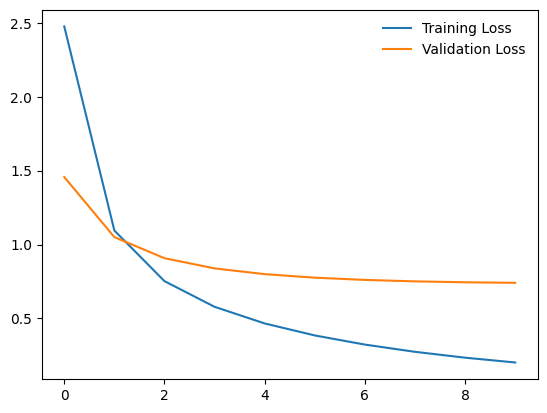

In [22]:
plt.plot(training_loss_count, label='Training Loss')
plt.plot(validation_loss_count, label='Validation Loss')
plt.legend(frameon=False)

<div class="alert alert-warning" role="alert">
<a id="submission"><h1 style="padding: 2rem;
          color:black;
          text-align:center;
          margin:0 auto;
          font-size:2rem;">
 Inference and Submission
</h1></a>
</div>

In [23]:
submission_data = []

with torch.inference_mode():
    for img_ids, y, X in test_dataloader:
        X = X.to(device)
        y_preds = model_effnet(X)
        y_preds = y_preds.argmax(dim=1)
        for img_id, y_pred in zip(img_ids, y_preds.cpu()):
            submission_data.append({'id': img_id, 'label': y_pred.item()})


In [24]:
submission_df = pd.DataFrame(submission_data)
submission_df.to_csv('submission.csv', index=False)        


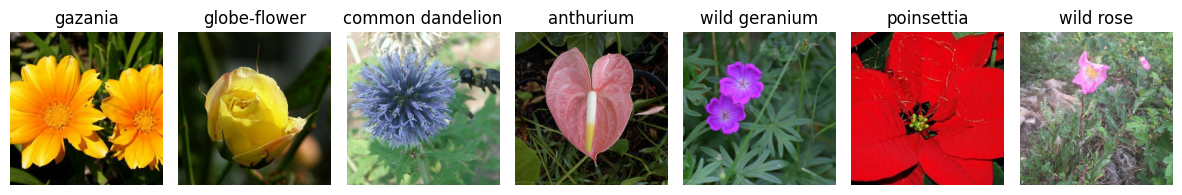

In [25]:
# Define the number of columns for the subplot grid
num_cols = len(submission_df.head(7))
fig, axes = plt.subplots(1, num_cols, figsize=(15, 5))

for i, (index, row) in enumerate(submission_df.head(7).iterrows()):
    name = FLOWER_NAMES[row['label']]
    selected_img = df_test.loc[df_test['id'] == row['id'], 'img'].squeeze()
    ax = axes[i]
    ax.imshow(selected_img)
    ax.set_title(name)
    ax.axis('off')
    
plt.subplots_adjust(wspace=0.1)
plt.show()